In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import time

start_time = time.time()

In [2]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")

np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 10)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)

%matplotlib inline

pd.set_option('display.max_columns', 100)

# Styles
sns.set_context('poster')
sns.set_style('darkgrid')
sns.set_palette("Paired")

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['text.color'] = 'k'

font = {'size'   : 10}

plt.rc('font', **font)


In [3]:
train_store = pd.read_pickle("../data/1_train_store_preprocessed.pkl").sort_values(['Store','Date'])
test_store = pd.read_pickle("../data/1_test_store_preprocessed.pkl").sort_values(['Store','Date'])
test = pd.read_csv("../data/test.csv", sep=",", parse_dates=['Date'],
                  dtype={'StateHoliday': str, 'SchoolHoliday':str})


In [4]:
forecast_total = pd.DataFrame()

In [5]:
import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm

In [6]:
import pandas as pd
from fbprophet import Prophet

In [7]:
NN = test['Store'].unique()
len(NN),max(NN)

(856, 1115)

In [8]:
N = 94
train_store_N = train_store[train_store['Store']==N]
test_store_N = test_store[test_store['Store']==N]

print(len(train_store_N),len(test_store_N))

train_store_N.tail()

942 48


Store  DayOfWeek       Date  Year  Month  Customers  Open  Promo  StateHoliday  SchoolHoliday  Sales  StoreType  Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  PromoInterval
4553     94          1 2015-07-27  2015      7        780     1      1             0              0  11168        2.0         1.0              14620.0                        3.0                       1.0     0.0              0.0              0.0            0.0
3438     94          2 2015-07-28  2015      7        701     1      1             0              0   8929        2.0         1.0              14620.0                        3.0                       1.0     0.0              0.0              0.0            0.0
2323     94          3 2015-07-29  2015      7        616     1      1             0              0   7718        2.0         1.0              14620.0                        3.0                       1.0     0.0              0.0              0.0            0.0
1208     94          4 2015-07-30  2015      7        649     1      1             0              0   7964        2.0         1.0              14620.0                        3.0                       1.0     0.0              0.0              0.0            0.0
93       94          5 2015-07-31  2015      7        694     1      1             0              0   8372        2.0         1.0              14620.0                        3.0                       1.0     0.0              0.0              0.0            0.0

In [9]:
df_tot = train_store_N[['Date','Sales']]
df_tot.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)
df_tot.head()

ds     y
1016188 2013-01-01     0
1015073 2013-01-02  5835
1013958 2013-01-03  5741
1012843 2013-01-04  5737
1011728 2013-01-05  4966

In [10]:
# Do we sell on sundays?
df_tot[df_tot['ds'].dt.dayofweek == 6]['y'].value_counts()
# No...

0    134
Name: y, dtype: int64

In [11]:
# REMOVE SUNDAYS
# df = df_tot
df = df_tot[df_tot['ds'].dt.dayofweek < 6]
df.head(10)

ds      y
1016188 2013-01-01      0
1015073 2013-01-02   5835
1013958 2013-01-03   5741
1012843 2013-01-04   5737
1011728 2013-01-05   4966
1009498 2013-01-07  11748
1008383 2013-01-08   9091
1007268 2013-01-09   7425
1006153 2013-01-10   7423
1005038 2013-01-11   7299

In [12]:
holidays_1 = train_store_N[['Date','StateHoliday','SchoolHoliday','Promo']]
holidays_1['StateHoliday'].value_counts(sort=False)

0    913
1     19
2      6
3      4
Name: StateHoliday, dtype: int64

In [13]:
holidays_test = test_store_N[['Date','StateHoliday','SchoolHoliday','Promo']]
holidays_test['StateHoliday'].value_counts(sort=False)

0    48
Name: StateHoliday, dtype: int64

In [14]:
#holidays_1[['StateHoliday','SchoolHoliday','Promo']].value_counts(sort=False)

In [15]:
holidays_tot = pd.DataFrame()

In [16]:
holiday_col = 'StateHoliday' 

list_id = holidays_1[holiday_col].unique()

print(holiday_col)
for k in list_id:
    if k == 0:
        continue
    print(k,end=' - ')
    y = holidays_1[holidays_1[holiday_col]==k]['Date']
    holidays_2 = pd.DataFrame({
      'holiday': f'{holiday_col} - {k}',
      'ds': pd.to_datetime(y.to_list()),
      'lower_window': 0,
      'upper_window': 1,
    })
    y = holidays_test[holidays_test[holiday_col]==k]['Date']
    holidays_3 = pd.DataFrame({
      'holiday': f'{holiday_col} - {k}',
      'ds': pd.to_datetime(y.to_list()),
      'lower_window': 0,
      'upper_window': 1,
    })
    print(f'{len(holidays_2)}+{len(holidays_3)}',end='   ')
    holidays_tot = pd.concat((holidays_tot, holidays_2,holidays_3),ignore_index=True)
holidays_tot.tail()

StateHoliday
1 - 19+0   2 - 6+0   3 - 4+0   

holiday         ds  lower_window  upper_window
24  StateHoliday - 2 2015-04-06             0             1
25  StateHoliday - 3 2013-12-25             0             1
26  StateHoliday - 3 2013-12-26             0             1
27  StateHoliday - 3 2014-12-25             0             1
28  StateHoliday - 3 2014-12-26             0             1

In [17]:
len(holidays_tot),len(df)

(29, 808)

In [18]:
m = Prophet(holidays=holidays_tot, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, seasonality_mode = 'multiplicative',
           changepoint_prior_scale=0.05)
m.add_country_holidays(country_name='DE')
#m2.add_regressor("my_holiday")
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [19]:
test_store['Date'].min(),test_store['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [20]:
future = m.make_future_dataframe(periods=6*8, freq='D')
future.min(),future.max()

(ds   2013-01-01
 dtype: datetime64[ns],
 ds   2015-09-17
 dtype: datetime64[ns])

In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

ds         yhat   yhat_lower    yhat_upper
846 2015-09-08  7128.863987  4971.701049   9390.038265
847 2015-09-09  6776.223986  4711.876366   9037.552485
848 2015-09-10  6878.301929  4793.312414   9013.907729
849 2015-09-11  7028.346023  4895.665493   9107.915249
850 2015-09-12  5445.791841  3297.949616   7438.794605
851 2015-09-13  7733.324692  5454.160898   9630.203285
852 2015-09-14  8900.420659  6904.184289  11023.040835
853 2015-09-15  7164.699110  5203.703688   9272.230010
854 2015-09-16  6850.078587  4784.837767   8892.822556
855 2015-09-17  6987.858118  4892.265249   9010.668017

In [22]:
mask = (forecast['ds'] >= test_store['Date'].min()) & (forecast['ds'] <= test_store['Date'].max())
forecast_main = forecast.loc[mask]
forecast_main['ds'].min(),forecast_main['ds'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [23]:
forecast_main['Store']=N
forecast_main.rename(columns={'ds': 'Date','yhat': 'Sales'}, inplace=True)
forecast_main['Sales']=np.round(forecast_main['Sales'])
forecast_main.loc[forecast_main['Date'].dt.dayofweek == 6,'Sales']=0
forecast_main[['Store','Date','Sales']].head(10)

Store       Date   Sales
808     94 2015-08-01  5654.0
809     94 2015-08-02     0.0
810     94 2015-08-03  9045.0
811     94 2015-08-04  7293.0
812     94 2015-08-05  6956.0
813     94 2015-08-06  7071.0
814     94 2015-08-07  7231.0
815     94 2015-08-08  5665.0
816     94 2015-08-09     0.0
817     94 2015-08-10  9119.0

In [24]:
forecast_total = pd.concat((forecast_total,forecast_main[['Store','Date','Sales']]))
forecast_total.head(10)

Store       Date   Sales
808     94 2015-08-01  5654.0
809     94 2015-08-02     0.0
810     94 2015-08-03  9045.0
811     94 2015-08-04  7293.0
812     94 2015-08-05  6956.0
813     94 2015-08-06  7071.0
814     94 2015-08-07  7231.0
815     94 2015-08-08  5665.0
816     94 2015-08-09     0.0
817     94 2015-08-10  9119.0

In [25]:
submission = pd.merge(test[['Id','Store','Date']], forecast_total,  how='left', left_on=['Store','Date'], right_on = ['Store','Date'])
submission[submission['Store']==N].head(10)
#new_df.head()

Id  Store       Date   Sales
72      73     94 2015-09-17  6988.0
928    929     94 2015-09-16  6850.0
1784  1785     94 2015-09-15  7165.0
2640  2641     94 2015-09-14  8900.0
3496  3497     94 2015-09-13     0.0
4352  4353     94 2015-09-12  5446.0
5208  5209     94 2015-09-11  7028.0
6064  6065     94 2015-09-10  6878.0
6920  6921     94 2015-09-09  6776.0
7776  7777     94 2015-09-08  7129.0

In [26]:
submission[['Id','Sales']].to_csv("./4_prophet.csv", sep=',', index=False)

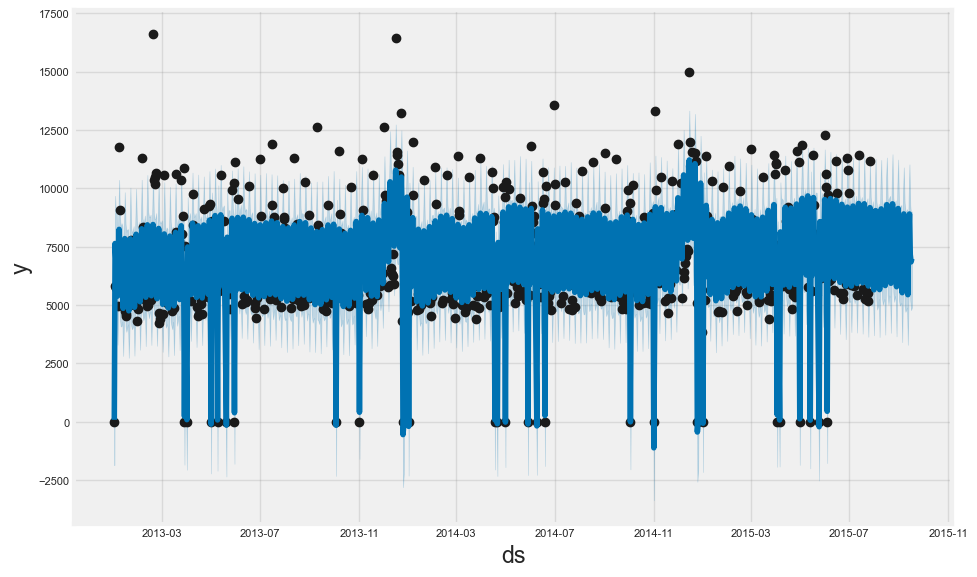

In [27]:
fig1 = m.plot(forecast)

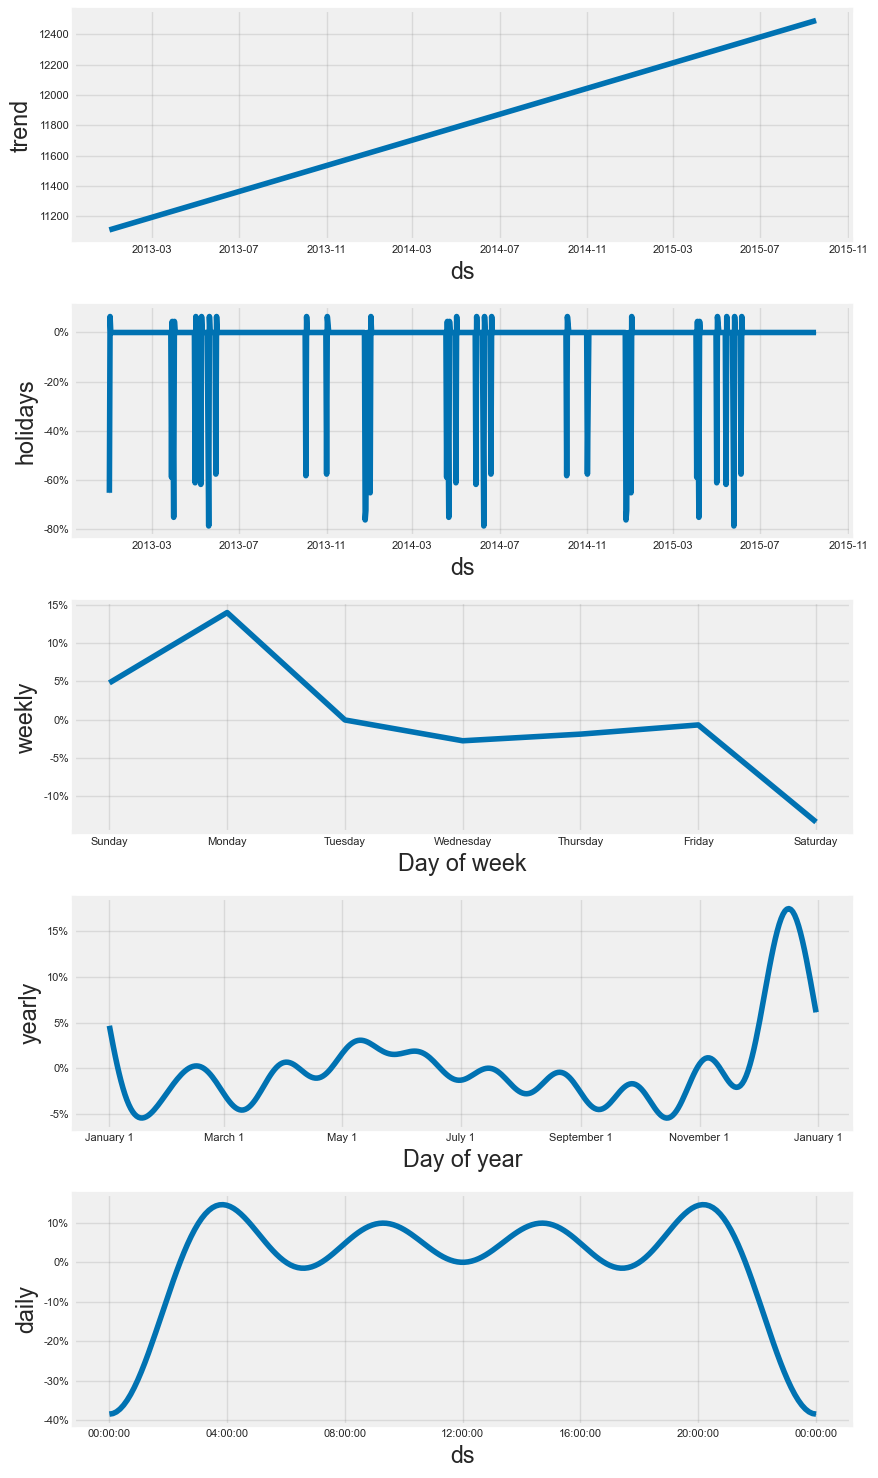

In [28]:
fig2 = m.plot_components(forecast)

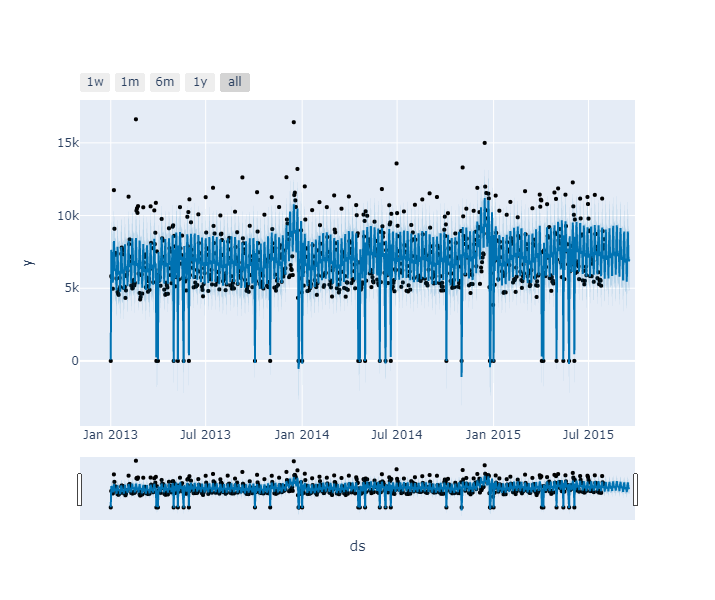

In [29]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

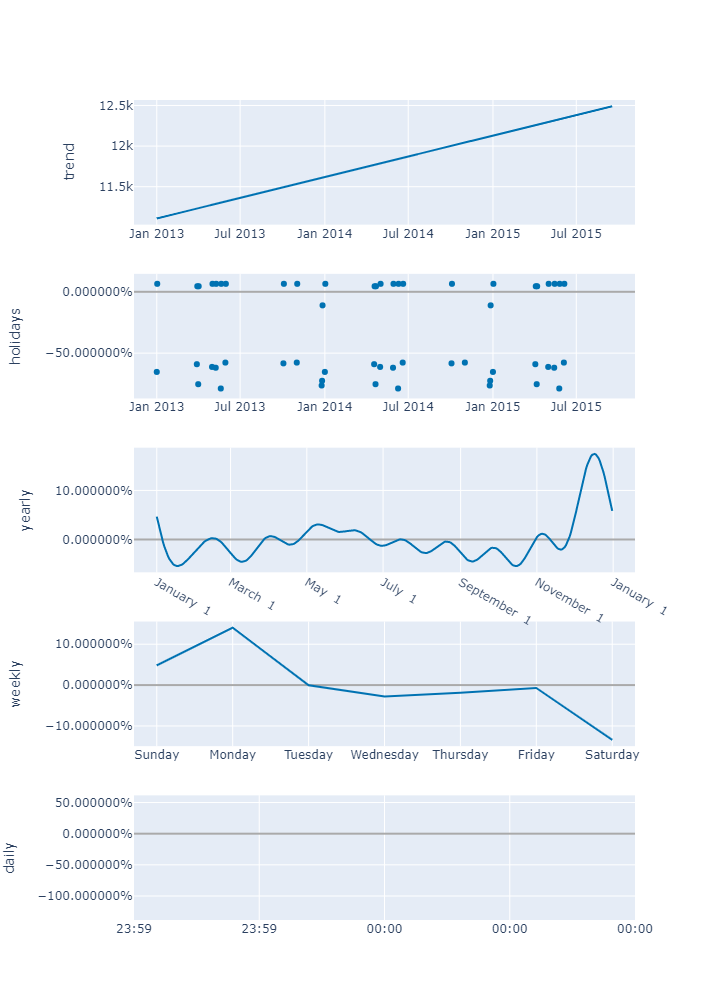

In [30]:
plot_components_plotly(m, forecast)

In [31]:
# Recordar que los domingos los quitamos del dataset para que no ensucie los gráficos.
# Hay que plancharles un 0 a esos días cuando lo entreguemos.